In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# $matplotlib --listでoptionを表示
#%matplotlib inline
%matplotlib inline

import datetime
import os

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
import gc

In [8]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.datasets import load_iris
iris_data = load_iris()
iris_df = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris_df["target"] = iris_data.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [14]:
X_name = list(iris_df.columns.values[:4])
Y_name = iris_df.columns.values[4]

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(iris_df[X_name].values, iris_df[Y_name].values,
                                                   test_size=0.2, random_state=18461)

parameter ref: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [44]:
param = {
    # core
    'objective': 'multiclass',
    'boosting': 'gbdt',
    "num_iteration": 1000,
    'learning_rate': 0.05,
    'num_leaves': 15,
    'num_threads': 2,
    "seed": 416863,
    # learning control
    'max_depth': -1,
    'min_data_in_leaf': 10,
    'min_sum_hessian_in_leaf': 0.01,
    "bagging_freq": 10,
    "bagging_fraction": 0.8,
    "early_stopping_round": 100,
    "lambda_l1": 0.01,
    "lambda_l2": 0.01,
    # io
    'verbosity': 1,
    # target
    "num_class": 3,
    "is_unbalance": False,  # binaryのみ
    # metric
    "metric": 'multi_logloss',
    }

In [45]:
kfold = KFold(n_splits=5)

Fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0722274	valid_1's multi_logloss: 0.0848409
[200]	training's multi_logloss: 0.019889	valid_1's multi_logloss: 0.0464372
[300]	training's multi_logloss: 0.00897669	valid_1's multi_logloss: 0.078815
Early stopping, best iteration is:
[210]	training's multi_logloss: 0.019577	valid_1's multi_logloss: 0.0372453


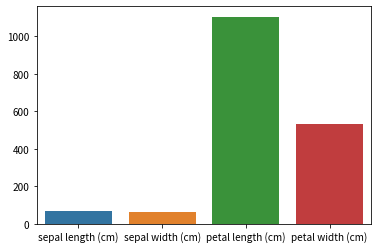

Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0679557	valid_1's multi_logloss: 0.102526
[200]	training's multi_logloss: 0.0167782	valid_1's multi_logloss: 0.124987
Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0438204	valid_1's multi_logloss: 0.0618347


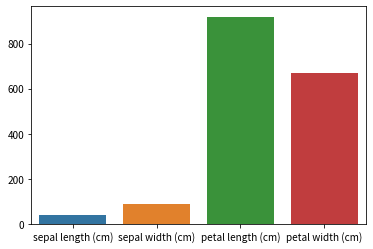

Fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0317019	valid_1's multi_logloss: 0.262819
[200]	training's multi_logloss: 0.00479316	valid_1's multi_logloss: 0.428576
Early stopping, best iteration is:
[110]	training's multi_logloss: 0.0256666	valid_1's multi_logloss: 0.253931


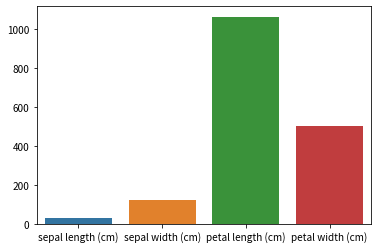

Fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0357818	valid_1's multi_logloss: 0.109428
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.044514	valid_1's multi_logloss: 0.0967648


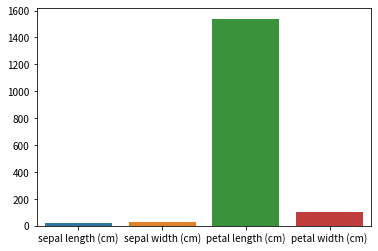

Fold 4
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.0455281	valid_1's multi_logloss: 0.261207
Early stopping, best iteration is:
[60]	training's multi_logloss: 0.118967	valid_1's multi_logloss: 0.174548


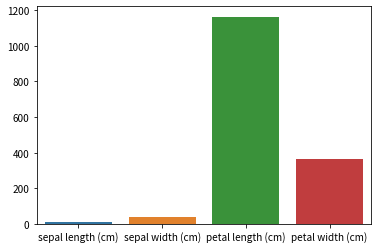

In [50]:
oof = np.zeros((len(X_train), 3))
predictions = np.zeros((5, len(X_test), 3))

for fold_, (trn_idx, val_idx) in enumerate(kfold.split(X_train, X_train)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(X_train[trn_idx], label=Y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], label=Y_train[val_idx])
    
    clf = lgb.train(param, trn_data, valid_sets=[trn_data, val_data], verbose_eval=100)
    oof[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    predictions[fold_] = clf.predict(X_test, num_iteration=clf.best_iteration)
    sns.barplot(x=X_name, y=clf.feature_importance(importance_type='gain'))
    plt.show()

In [54]:
pred = np.argmax(np.mean(predictions, axis=0), axis=1)

In [55]:
Y_test == pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True])